# Car Detection

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Implement object detection for autonomous driving using the "You Only Look Once" algorithm.

[You Only Look Once (YOLO)](https://arxiv.org/pdf/1506.02640) is a popular real-time object detection system that achieves high accuracy requiring only one forward propagation through the network to make predictions. It generates the recognized objects along with the bounding boxes.

## Download the "Yet Another Darknet 2 Keras" repository

[Yet Another Darknet 2 Keras (YAD2K)](https://github.com/allanzelener/YAD2K) is a repository that helps to convert the [Darknet](https://pjreddie.com/darknet/) YOLOv2 model to a Keras model. The YAD2K code was modified to work with [Keras 3](https://keras.io/keras_3/).

In [1]:
%%bash

if [ -e "/tmp/YAD2K.zip" ]; then
    echo "YAD2K.zip already exists!"
else
    gdown 1MA4g7d-pJEChYey2PotscZXq9EJr0K2H -O /tmp/
fi

unzip -qn /tmp/YAD2K.zip -d /tmp

YAD2K.zip already exists!


## Import libraries

In [2]:
import sys
sys.path.insert(0, '/tmp/YAD2K')
from yad2k.utils.utils import preprocess_image, read_classes, read_anchors, draw_boxes
from yad2k.models.keras_yolo import space_to_depth_x2, space_to_depth_x2_output_shape, yolo_head, yolo_eval
import os
from keras import models
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML

2025-01-04 12:24:40.493598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736015080.519247  102025 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736015080.528497  102025 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 12:24:40.553545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize the dataset

In [3]:
path = "/tmp/YAD2K/images"
files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(".jpg") and file.startswith("0")]
frames = []

fig, ax = plt.subplots()

for file in files:
    image = Image.open(file)
    plt.tight_layout()
    ax.set_title("Frames")
    ax.axis("off")
    frame = ax.imshow(image, animated=True)
    frames.append([frame])
    
anim = animation.ArtistAnimation(fig, frames, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(anim.to_html5_video())

## Download the Darknet YOLOv2 model and convert it to a Keras model

In [4]:
%%bash

wget -nc --progress=bar:force:noscroll https://pjreddie.com/media/files/yolov2.weights -P /tmp/YAD2K/model_data
wget -nc --progress=bar:force:noscroll https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2.cfg -P /tmp/YAD2K/model_data

if [ -e "/tmp/YAD2K/model_data/yolov2.keras" ]; then
    echo "yolov2.keras already exists!"
else
    /tmp/YAD2K/yad2k.py /tmp/YAD2K/model_data/yolov2.cfg /tmp/YAD2K/model_data/yolov2.weights /tmp/YAD2K/model_data/yolov2.keras
fi

File '/tmp/YAD2K/model_data/yolov2.weights' already there; not retrieving.

File '/tmp/YAD2K/model_data/yolov2.cfg' already there; not retrieving.



yolov2.keras already exists!


## Load the Keras model, classes and anchor boxes

In [5]:
model = models.load_model("/tmp/YAD2K/model_data/yolov2.keras", 
                          custom_objects={'space_to_depth_x2': space_to_depth_x2, 'space_to_depth_x2_output_shape': space_to_depth_x2_output_shape})
model.summary()

I0000 00:00:1736015107.116582  102025 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1624 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 608, 608,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 608, 608,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 608, 608,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 608, 608,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 304, 304,  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 304, 304,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 304, 304,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 304, 304,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 152, 152,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 152, 152,  │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 152,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 152, 152,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 152, 152,  │      8,192 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 152,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 152, 152,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 152, 152,  │     73,728 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 152,  │        512 │ conv2d_4[0][0]  

 Total params: 50,983,561 (194.49 MB)

 Trainable params: 50,962,889 (194.41 MB)

 Non-trainable params: 20,672 (80.75 KB)

In [6]:
classes = read_classes("/tmp/YAD2K/model_data/coco_classes.txt")
anchors = read_anchors("/tmp/YAD2K/model_data/yolov2_anchors.txt")

## Evaluate the model

I0000 00:00:1736015109.109839  102025 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-04 12:25:09.617921: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-04 12:25:09.692711: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-04 12:25:09.795716: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

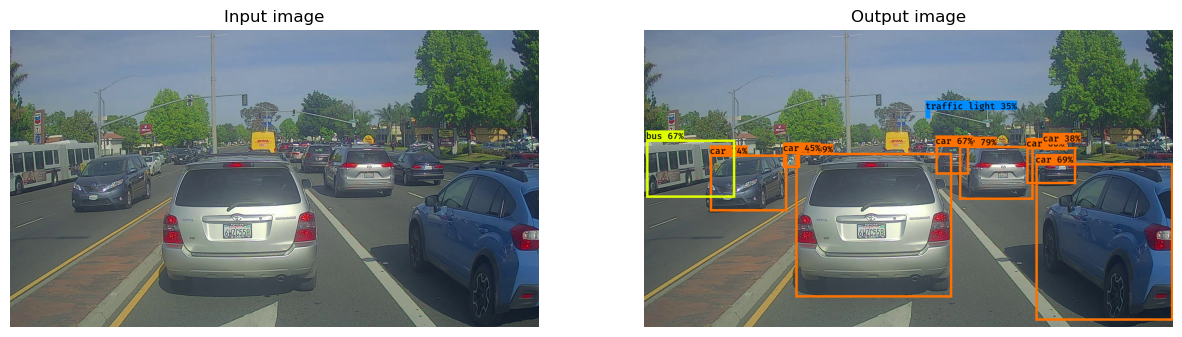

In [7]:
file = "/tmp/YAD2K/images/test.jpg"
image, image_data = preprocess_image(file, model_image_size=(608, 608))
model_outputs = model(image_data)
outputs = yolo_head(model_outputs, anchors, len(classes))
out_boxes, out_scores, out_classes = yolo_eval(outputs, [image.size[1], image.size[0]], score_threshold=0.3, iou_threshold=0.5)
output_image = draw_boxes(image.copy(), out_boxes, out_classes, classes, out_scores)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(image)
axs[0].axis("off")
axs[0].set_title("Input image")

axs[1].imshow(output_image)
axs[1].axis("off")
axs[1].set_title("Output image")

plt.show()

In [8]:
path = "/tmp/YAD2K/images"
files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if file.endswith(".jpg") and file.startswith("0")]
frames = []

fig, ax = plt.subplots()

for file in files:
    image, image_data = preprocess_image(file, model_image_size=(608, 608))
    model_outputs = model(image_data)
    outputs = yolo_head(model_outputs, anchors, len(classes))
    out_boxes, out_scores, out_classes = yolo_eval(outputs, [image.size[1], image.size[0]], score_threshold=0.3, iou_threshold=0.5)
    output_image = draw_boxes(image.copy(), out_boxes, out_classes, classes, out_scores)
    
    plt.tight_layout()
    ax.set_title("Output frames")
    ax.axis("off")
    frame = ax.imshow(output_image, animated=True)
    frames.append([frame])
    
anim = animation.ArtistAnimation(fig, frames, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(anim.to_html5_video())